In [1]:
from path import Path 
from scipy.stats import pearsonr, spearmanr, wilcoxon

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq

import os, warnings 
warnings.filterwarnings('ignore') 
import stan

figsize = stan.figsize
fontsize = stan.fontsize
dpi = stan.dpi

/Users/zhanglinan/anaconda3/envs/bioinfo/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/zhanglinan/anaconda3/envs/bioinfo/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/zhanglinan/anaconda3/envs/bioinfo/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Inferring TF Activity using STAN

In [2]:
path = Path('outputs_lymphnode')
if not os.path.exists(path):
    os.makedirs(path)

The function `stan.datasets.visium_sge()` downloads the dataset from 10x Genomics and returns an AnnData object that contains counts, images and spatial coordinates. If `sample_id` is not provided in [this page](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.visium_sge.html), download the files from [the database](https://www.10xgenomics.com/datasets).

In [3]:
sample_id = "V1_Human_Lymph_Node" # not need to predownload this dataset
adata = stan.read_visium_sge(sample_id=sample_id, min_cells=5, min_counts=5000)

### Gene-TF Matrix Construction

Adds transcription factor (TF)-gene interaction matrix to adata. Filters interactions by:
- Minimum proportion of cells where gene is expressed (default = 0.2)
- Minimum TFs per gene (default = 5)
- Minimum genes per TF (default = 10)

Uses human TF-target database as source

In [4]:
adata = stan.add_gene_tf_matrix(
    adata, 
    min_cells_proportion=0.2, 
    min_tfs_per_gene=5, 
    min_genes_per_tf=10,
    gene_tf_source="hTFtarget", 
    tf_list="humantfs", 
    source_dir="resources/"
)

### Spatial Feature Extraction

Calculates pixel intensity features from spatial coordinates
- window size (default = 25)

In [5]:
stan.pixel_intensity(adata, windowsize=25)

### Kernel Matrix Construction
Builds spatial similarity kernel using pixel intensity-based kernel (then choose 250 sigular values after SVD) with 10% weight given to image features compared to the full spatial coordinates

In [6]:
stan.make_kernel_from_pixel(adata, n=250, im_feats_weight=0.1)

### Data Normalization
Normalizes counts to 10,000 reads per cell (CPT normalization) and Applies square root transform and stores in `scaled` layer

In [7]:
sc.pp.normalize_total(adata)
adata.layers['scaled'] = np.sqrt(adata.to_df())

### STAN Model Fitting

In [8]:
# Splits data into 10 folds for evaluation
stan.assign_folds(adata, n_folds=10, random_seed=0)

# Creates STAN model using the sqrt-transformed data
stan_model = stan.Stan(adata, layer='scaled')

In [9]:
# Performs grid search over lambda parameters with specified number of optimization steps
stan_model.fit(
    n_steps=4, 
    stages=1,
    grid_search_params={'lam1': [1e-4, 1e2], 'lam2': [1e-4, 1e2]}
)
print(stan_model.params)  # Print learned parameters

Time elapsed: 27.81 seconds
{'lam1': 100.0, 'lam2': 100.0}


In [10]:
# Evaluates on held-out data (fold=-1 means all data)
cor, gene_cor = stan_model.evaluate(fold=-1)

# Print mean correlation metrics
print("Spot-wise correlation:" + str(round(np.nanmean(cor), 4))) # We are interested in this correlation
print("Gene-wise correlation: " + str(round(np.nanmean(gene_cor), 4)))

Spot-wise correlation:0.2243
Gene-wise correlation: 0.0736


In [11]:
# Store results in adata object
adata.obs['pred_cor_stan'] = cor  # Spot-level correlation
adata.var['pred_cor_stan'] = gene_cor  # Gene-level correlation

# Stores TF activities in obsm with spot x TF matrix
adata.obsm['tfa_stan'] = pd.DataFrame(
    stan_model.W_concat.T, 
    index=adata.obs_names, 
    columns=adata.uns['tf_names']
)

adata.write(path / ('adata_'+sample_id+'.h5ad'))

## Analysis of Inferred TF Activity

In [12]:
# Input of STAN
adata = stan.read_visium_sge(sample_id=sample_id, min_cells=5, min_counts=5000)
adata = stan.annotate_lymphnode(adata, fpath="resources/lymphnode_annotation")
adata

AnnData object with n_obs × n_vars = 3989 × 21261
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'germinal_center'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial', 'celltype', 'celltype_raw'
    layers: 'raw'

In [13]:
# output of STAN
adata_stan = sc.read_h5ad(f"outputs_stan/adata_{sample_id}.h5ad")
adata_stan = stan.annotate_lymphnode(adata_stan, fpath="resources/lymphnode_annotation")
adata_stan

AnnData object with n_obs × n_vars = 3989 × 8931
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'pred_cor_stan', 'pred_cor_ridge', 'germinal_center'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'fold', 'pred_cor_stan', 'pred_cor_ridge'
    uns: 'spatial', 'tf_names'
    obsm: 'kernel', 'pixel', 'spatial', 'tfa_ridge', 'tfa_stan', 'celltype', 'celltype_raw'
    varm: 'gene_tf'
    layers: 'raw', 'scaled'
    obsp: 'kernel'

Extracts the inferred TF activity matrix.

In [14]:
adata_tfa = stan.get_activity(adata_stan, key='tfa_stan')

For mRNA expression, normalizes each spot by total counts over all genes.

In [15]:
sc.pp.normalize_total(adata)
adata.layers['scaled'] = np.sqrt(adata.to_df())

sc.pp.normalize_total(adata_stan)
adata_stan.layers['scaled'] = np.sqrt(adata_stan.to_df())

### Visualizing the H&E stained image and the germinal centers

Text(0, 0.5, '')

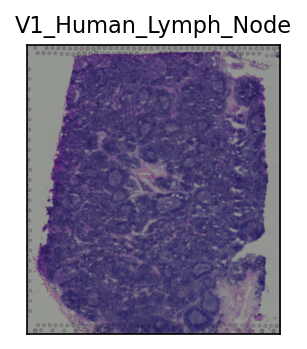

In [16]:
fig, ax = plt.subplots(1,1, figsize=(figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adata, show=False, ax=ax, title=sample_id)
ax.set_xlabel("")
ax.set_ylabel("")

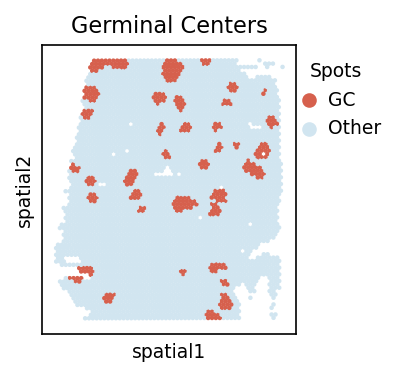

In [17]:
fig, axes = plt.subplots(1,1, figsize=(figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adata_stan, color='germinal_center', size=1.8, alpha_img=0, 
              palette={"GC":'#d6604d', "Other":'#d1e5f0'},
              ax=axes, show=False, legend_fontsize=fontsize)
axes.set_title('Germinal Centers')
plt.legend(title="Spots", loc='upper right', bbox_to_anchor=(1.4, 1), columnspacing=0.5, handletextpad=0, frameon=False)

### Embedding and Clustering

Computes a similarity measure between TFa/mRAN clustering and germincal centers.

In [18]:
import sklearn
from sklearn.preprocessing import OrdinalEncoder
def compute_ari(adata, cluster_1, cluster_2, cluster1_target):
    label_1 = np.array(adata.obs[cluster_1]).reshape(-1,1)
    label_1[label_1!=cluster1_target]='0'
    sklearn_encoder = OrdinalEncoder()
    encoder_1 = sklearn_encoder.fit_transform(label_1)

    label_2 = np.array(adata.obs[cluster_2]).reshape(-1,1)
    sklearn_encoder = OrdinalEncoder()
    encoder_2 = sklearn_encoder.fit_transform(label_2)

    s = sklearn.metrics.adjusted_rand_score(encoder_1.flatten(), encoder_2.flatten())
    return s

Clustering based on TF activity

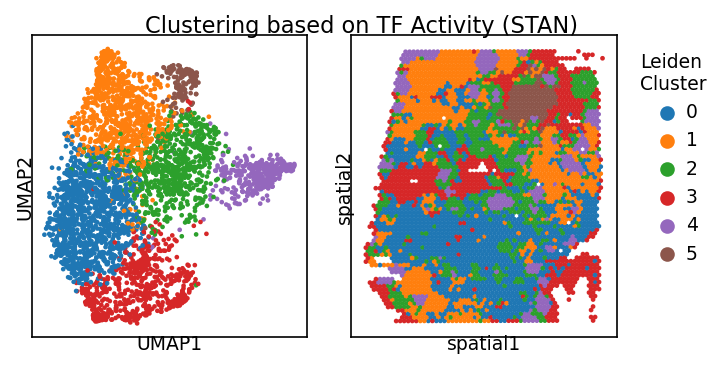

In [19]:
adata_tfa_scaled = adata_tfa.copy()[:, adata_tfa.to_df().dropna(axis=1).columns]
sc.pp.scale(adata_tfa_scaled)
sc.pp.neighbors(adata_tfa_scaled, n_neighbors=100)
sc.tl.umap(adata_tfa_scaled, min_dist=0.01)
sc.tl.leiden(adata_tfa_scaled, resolution=0.8)
stan.plot_umap(adata_tfa_scaled, title='Clustering based on TF Activity (STAN)')

In [20]:
compute_ari(adata_tfa_scaled, 'leiden', 'germinal_center','4') 

0.7580794175072664

Clustering based on mRNA expression

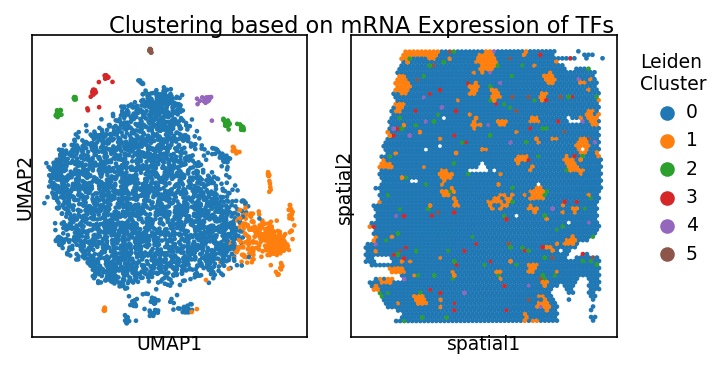

In [21]:
tfs = adata.var_names.intersection(adata_stan.varm['gene_tf'].columns)
adata_scaled = adata.copy()
sc.pp.log1p(adata_scaled)
sc.pp.scale(adata_scaled)
adata_scaled_subset = adata_scaled[:, tfs].copy()
sc.pp.neighbors(adata_scaled_subset, n_neighbors=100)
sc.tl.umap(adata_scaled_subset, min_dist=0.01)
sc.tl.leiden(adata_scaled_subset, resolution=0.5) # res = 1
stan.plot_umap(adata_scaled_subset, title='Clustering based on mRNA Expression of TFs')

In [22]:
compute_ari(adata_scaled_subset, 'leiden', 'germinal_center','1')

0.6524800557401369

### Visualizing TFa in spatial coordinates
Rank TFs and genes for germinal centers and nongerminal centers.

In [23]:
def get_average_expression_by_group(adata):
    df = pd.DataFrame(adata.X, 
                  index=adata.obs['germinal_center'], 
                  columns=adata.var_names)

    # Compute mean by group
    average_expression = df.groupby(level=0).mean().T
    return average_expression['GC'] - average_expression['Other']

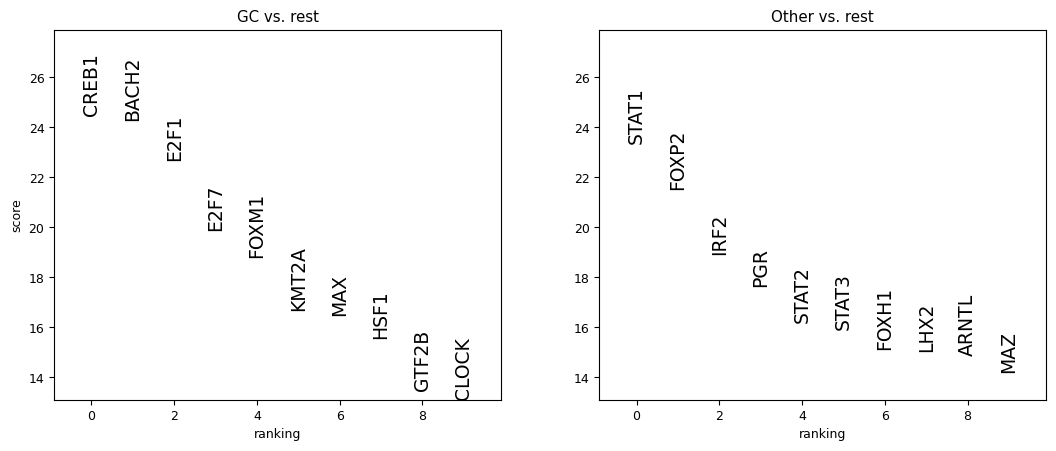

In [24]:
adata_tfa_scaled.obs['germinal_center'] = adata_tfa_scaled.obs['germinal_center'].astype('category')
sc.tl.rank_genes_groups(adata_tfa_scaled, groupby='germinal_center', method="wilcoxon")
sc.pl.rank_genes_groups(adata_tfa_scaled, fontsize=fontsize*1.5, n_genes=10)

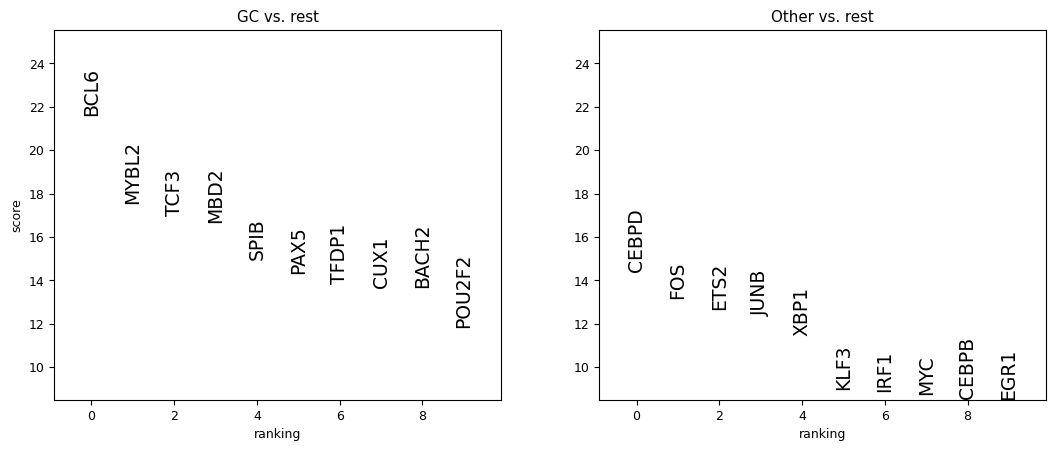

In [25]:
adata_scaled_subset.obs['germinal_center'] = adata_scaled_subset.obs['germinal_center'].astype('category')
sc.tl.rank_genes_groups(adata_scaled_subset, groupby='germinal_center', method="wilcoxon")
sc.pl.rank_genes_groups(adata_scaled_subset, fontsize=fontsize*1.5, n_genes=10)

Finds the edges of the germinal centers.

In [26]:
import auxiliary_lymphnode as auxln
points, edges = auxln.find_edges(adata)

Creates spatial plots for inferred TF activity of the top 3 ranked TFs in the germinal centers.

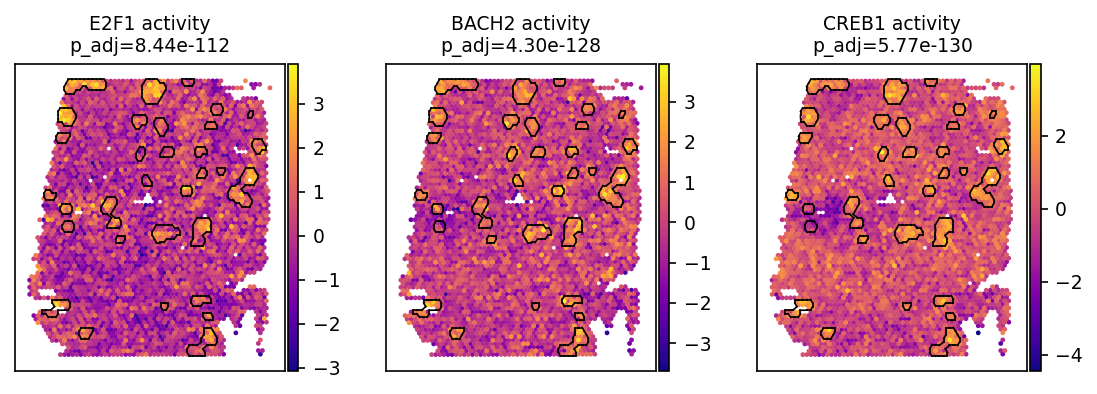

In [27]:
stan.plot_spatial_activity(adata_tfa_scaled, ['E2F1', 'BACH2', 'CREB1'], points, edges)

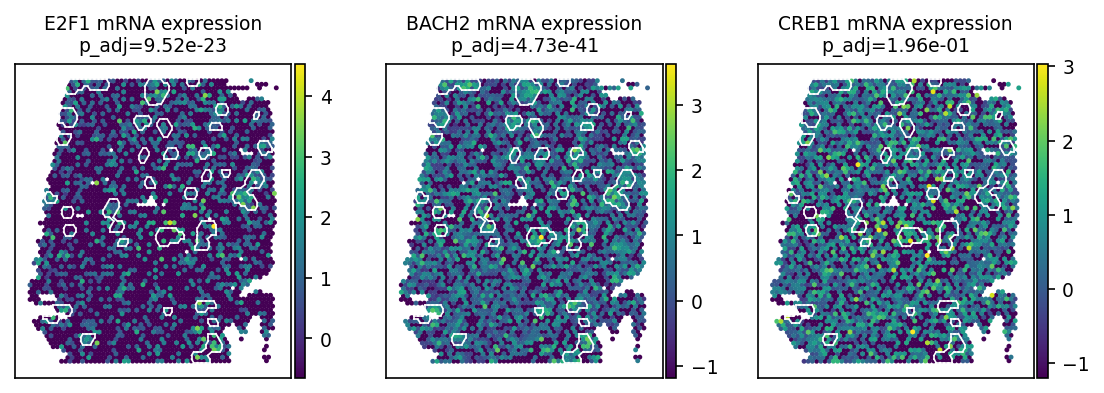

In [28]:
stan.plot_spatial_expression(adata_scaled_subset, ['E2F1', 'BACH2', 'CREB1'], points, edges)

### Celltype Proportion and TF Activity
Merges some celltype groups with small proportion.

In [29]:
df_celltype = auxln.merge_celltypes(adata)
adata_tfa_scaled.obsm['celltype_major'] = df_celltype  
mat_cor_tfa, mat_cor_rna = auxln.make_cor_dataframe(adata_scaled_subset, adata_tfa_scaled, celltype_label='celltype_major')

Correlates celltype proportion with TF activity and mRNA expression.

In [30]:
def plot_spatial_ct_tf(ct, tf):
    fig, axs = plt.subplots(1,3, figsize=(figsize*3,figsize), dpi=300)
    sc.pl.spatial(sq.pl.extract(adata_tfa_scaled, "celltype_major"),
                  color=ct, alpha_img=0, ax=axs[0], show=False, cmap="rocket", size=1.8,
                  legend_fontsize=fontsize)
    sc.pl.spatial(adata_scaled_subset, color=tf, alpha_img=0, ax=axs[1],show=False, cmap="viridis", 
                  legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata_tfa_scaled, color=tf, alpha_img=0, ax=axs[2],show=False, cmap="plasma", 
                  legend_fontsize=fontsize, size=1.8)

    axs[0].set_title(f'{ct} proportion', fontsize=fontsize)
    axs[1].set_title(f"{tf} mRNA expression\nPearson r={mat_cor_rna.loc[tf, ct]:.4f}", fontsize=fontsize)
    axs[2].set_title(f'STAN-inferred {tf} activity\nPearson r={mat_cor_tfa.loc[tf, ct]:.4f}', fontsize=fontsize)
    
    for i in range(3):
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
    plt.tight_layout(pad=0.6)

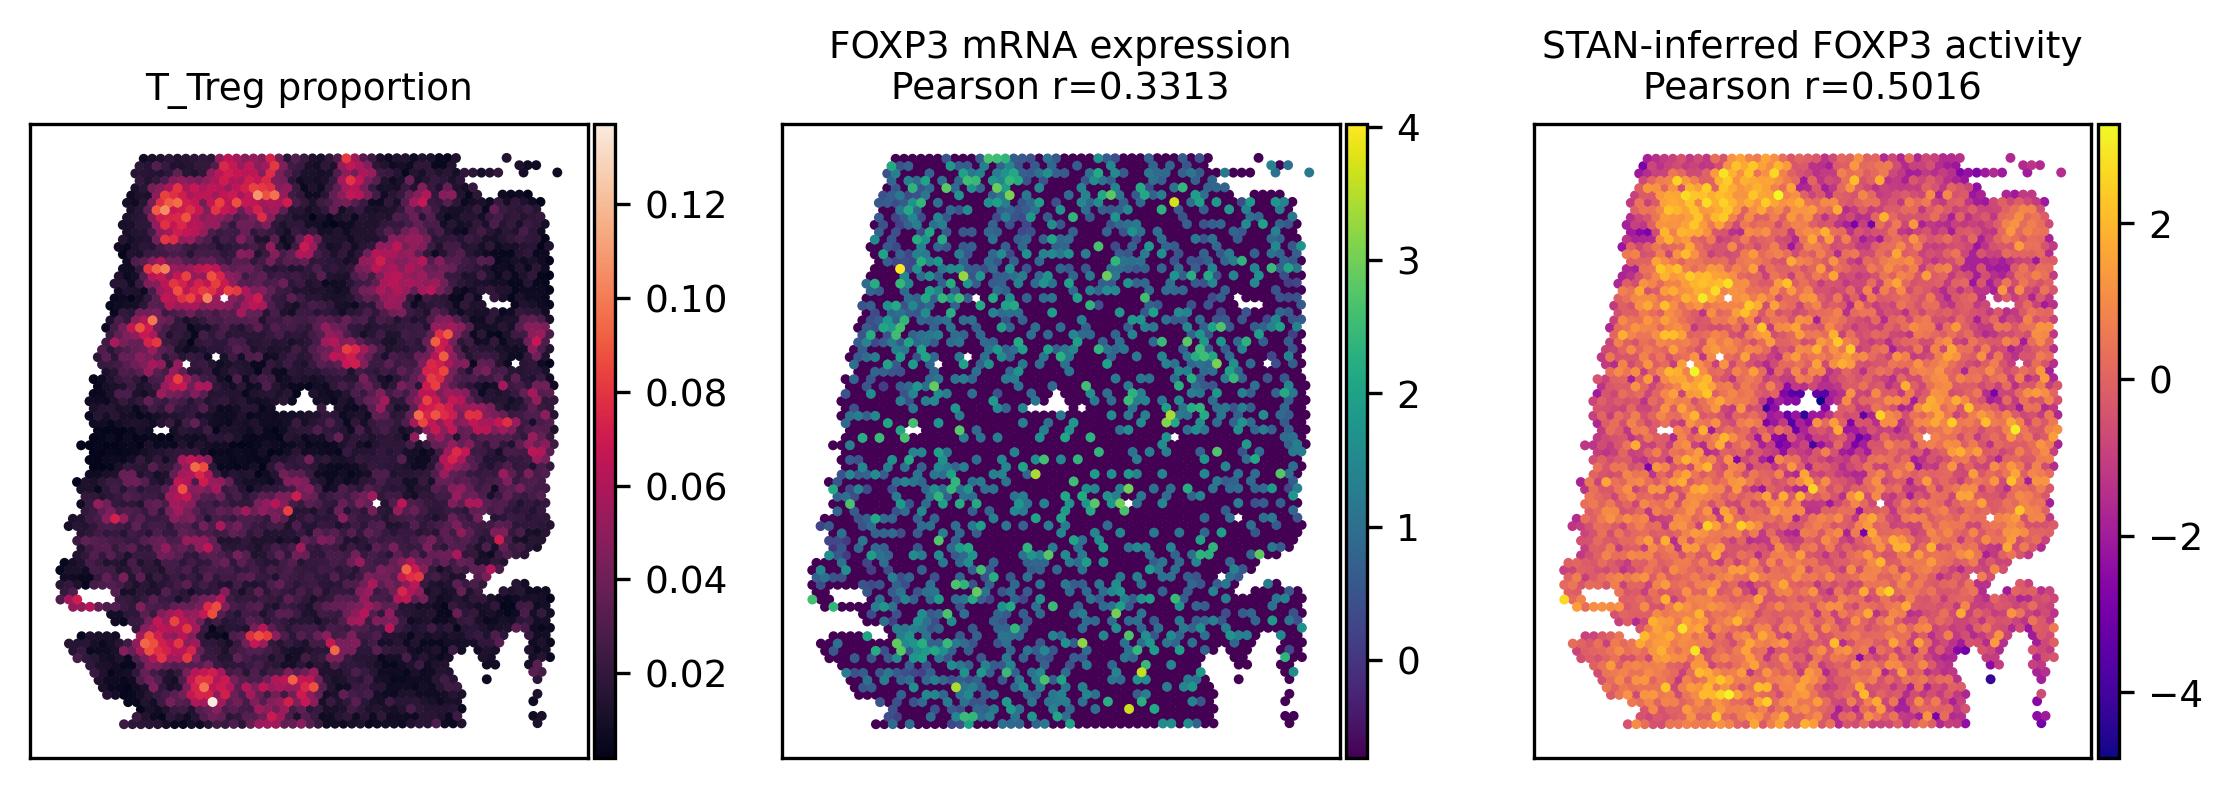

In [31]:
plot_spatial_ct_tf(ct = "T_Treg", tf = "FOXP3")

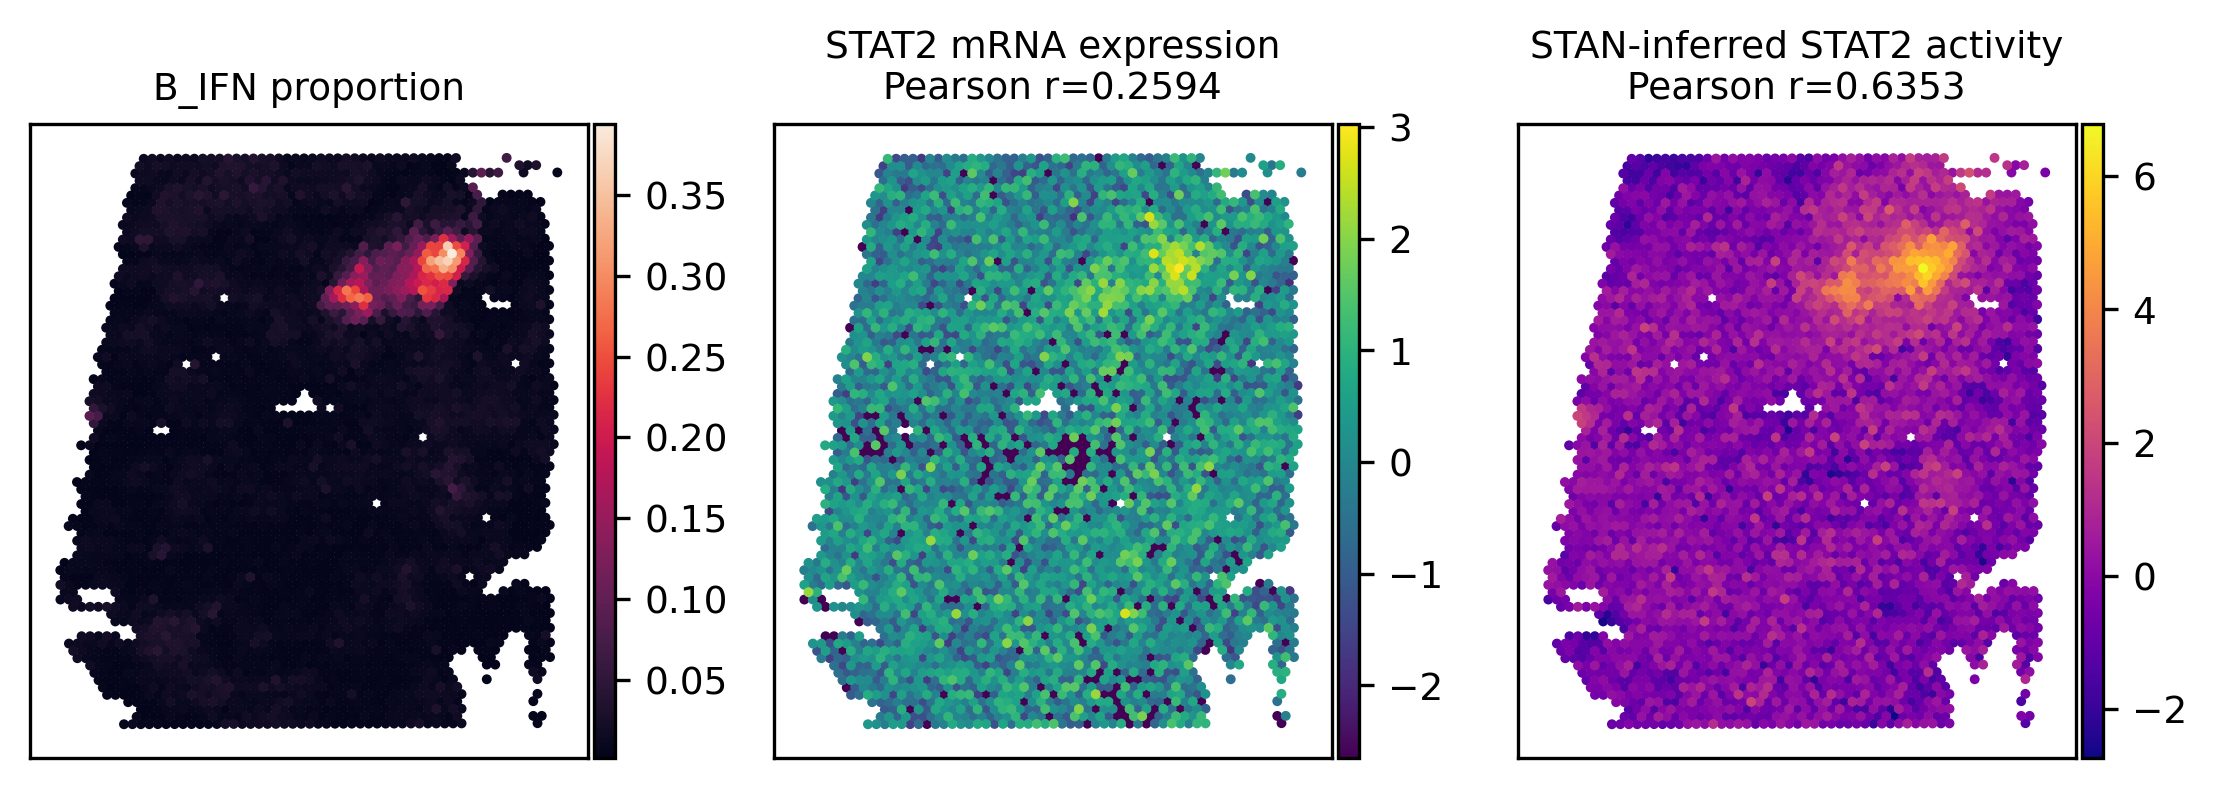

In [32]:
plot_spatial_ct_tf(ct = "B_IFN", tf = "STAT2")

Computes celltype-specific TF activity scores

In [33]:
df_ct_tf = auxln.infer_celltype_activity(adata_tfa_scaled)

Selects TFs and celltypes for visualization.

In [34]:
# df_filtered = df_ct_tf.query("negative_log_p_adj>2.8").query("coef>4 | coef < -4").query("r_squared>0.095")
df_filtered = df_ct_tf.query("neg_log_p_adj>5").query("coef>20")
tf_list = df_filtered['tf'].unique()
ct_list = df_filtered['ct'].unique()
print(tf_list)
print(ct_list)
df_ct_tf.query("tf in @tf_list and ct in @ct_list").to_csv('df2plot_inR/lymphnode_tf_by_celltype.csv')

['ATF5' 'BACH2' 'CREB1' 'CREB3' 'E2F1' 'E2F7' 'ELK3' 'ETV4' 'ETV6' 'FOXM1'
 'FOXP2' 'FOXP3' 'GTF2B' 'HNF1B' 'HSF1' 'IRF2' 'JUND' 'KLF1' 'KMT2A'
 'LEF1' 'LHX2' 'MAFB' 'MAX' 'MAZ' 'MYB' 'NFYC' 'PBX1' 'RFX3' 'SOX2'
 'STAT1' 'STAT2' 'STAT3' 'STAT4' 'STAT5B' 'STAT6' 'TBX21' 'TCF21' 'ZFHX3']
['B_activated' 'B_Cycling' 'B_GC' 'FDC' 'T_CD8+' 'T_Treg' 'Endo'
 'B_plasma' 'Monocytes' 'B_mem' 'DC' 'T_CD4+' 'T_TfR' 'B_preGC' 'B_IFN'
 'NK' 'NKT' 'VSMC' 'Macrophages' 'B_naive']


In [35]:
def plot_heatmap(df_ct_tf, tf_list, ct_list, clip=10):
    data = df_ct_tf.query("tf in @tf_list and ct in @ct_list")
    data.columns = ['tf', 'ct', 'Cell type-specific TF Score', 'pval', 'p_adj', '-log(p_adj)']
    x = 'tf'
    y = 'ct'
    hue = 'Cell type-specific TF Score'

    data[x] = data[x].astype("category")
    data[y] = data[y].astype("category")
    x_lab = data[x].cat.categories
    y_lab = data[y].cat.categories

    f = sns.clustermap(data.pivot(index=y, columns=x, values=hue),figsize=(0.1,0.1), cmap='PiYG')
    x_lab = x_lab[f.dendrogram_col.reordered_ind]
    y_lab = y_lab[f.dendrogram_row.reordered_ind]
    print(x_lab)
    print(y_lab)

    data[x] = data[x].cat.reorder_categories(x_lab)
    data[y] = data[y].cat.reorder_categories(y_lab)
    data = data.sort_values([x, y])
    data[hue] = data[hue].clip(-clip, clip)

    figsize = 0.2
    plt.figure(figsize=(figsize*len(x_lab), figsize*len(y_lab)), dpi=dpi)
    plt.rc('font', size=fontsize) 
    ax = sns.scatterplot(data=data,x=x, y=y, palette="PiYG_r", hue=hue, size="-log(p_adj)")
    plt.legend(bbox_to_anchor=(1.5,1.), loc='upper right', 
        columnspacing=0.5, handletextpad=0, frameon=False, fontsize=fontsize)

    ax.set_xticklabels(x_lab, rotation = 90)
    ax.set_xlim(-0.5, -0.5+len(x_lab))
    ax.set_ylim(-0.5, -0.5+len(y_lab))
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.close(f.fig)

Index(['STAT3', 'FOXP2', 'STAT1', 'MAZ', 'LHX2', 'ELK3', 'TCF21', 'SOX2',
       'HNF1B', 'ETV6', 'NFYC', 'RFX3', 'ETV4', 'MAFB', 'ATF5', 'PBX1',
       'BACH2', 'CREB1', 'HSF1', 'FOXM1', 'KMT2A', 'E2F1', 'MAX', 'GTF2B',
       'E2F7', 'LEF1', 'KLF1', 'STAT4', 'STAT6', 'CREB3', 'FOXP3', 'MYB',
       'ZFHX3', 'STAT5B', 'TBX21', 'JUND', 'IRF2', 'STAT2'],
      dtype='object')
Index(['B_Cycling', 'B_GC', 'FDC', 'B_IFN', 'T_CD8+', 'T_Treg', 'T_CD4+',
       'T_TfR', 'B_naive', 'NK', 'B_activated', 'B_plasma', 'Macrophages',
       'Endo', 'Monocytes', 'NKT', 'VSMC', 'B_mem', 'B_preGC', 'DC'],
      dtype='object')


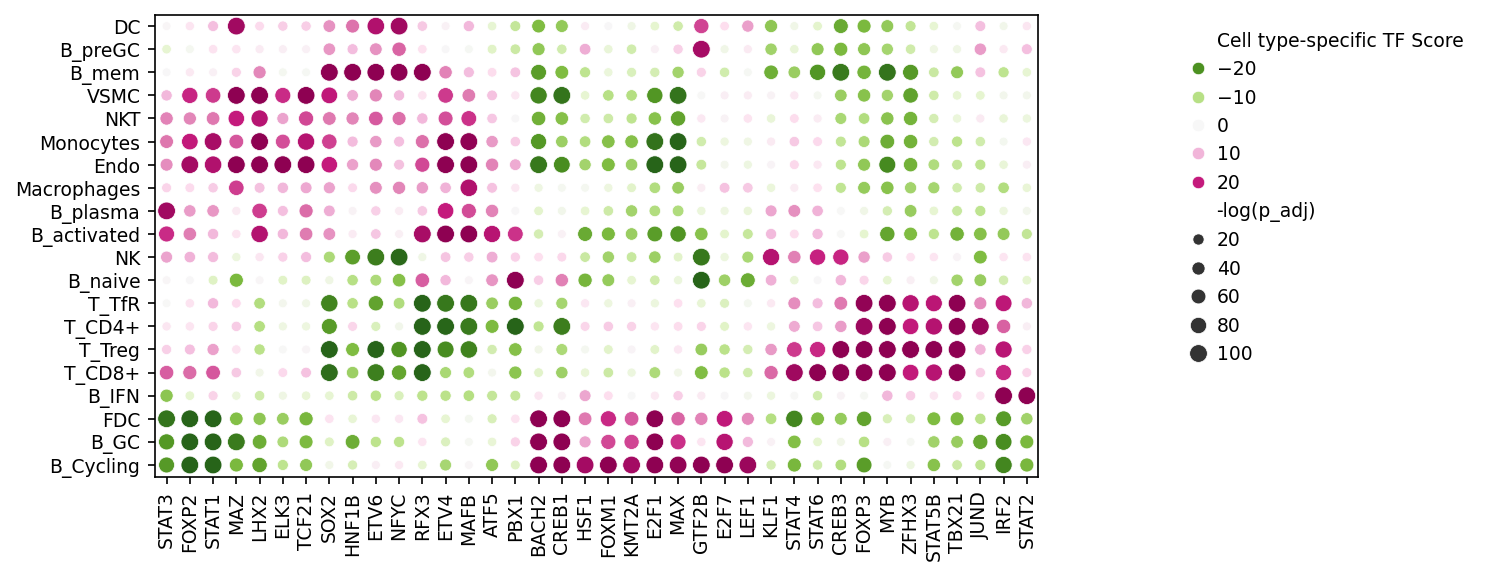

In [36]:
plot_heatmap(df_ct_tf, tf_list, ct_list, clip=25)